## Portfolio Optimization

Portfolio optimization models are concerned with investment where there are typically two criteria: expected return and risk. The investor wants the former to be high and the latter to be low. 

There is a variety of measures of risk. The most popular measure of risk has been variance in return. Even though there are some problems with it, we will first look at it very closely.

### The Markowitz Mean/Variance Portfolio Model
The portfolio model, introduced by Markowitz, assumes an investor has two considerations when constructing an investment portfolio: expected return and variance in return (i.e., risk). Variance measures the variability in realized return around the expected return. 

The Markowitz model requires two major kinds of information: 

* the estimated expected return for each candidate investment;
* the covariance matrix of returns. 

The covariance matrix characterizes not only the individual variability of the return on each investment, but also how each investment’s return tends to move with other investments. 

Part of the appeal of the Markowitz model is it can be solved by efficient quadratic programming methods. Quadratic programming is the name applied to the class of models in which the objective function is a quadratic function and the constraints are linear. Thus, the objective function is allowed to have terms that are products of two variables such as $x_i^2$ and $x_i\cdot x_j$.

### Example
Throughout this lesson we will use real market data stored in [portfolio_data.csv](https://drive.google.com/file/d/1srCzNlKVY_LHRpkaKoUynnmI0KImfT6Y/view?usp=sharing).
The sample includes, for each entry, a date and the corresponding closing price of five company stocks:

In [6]:
import pandas as pd

temp = pd.read_csv("portfolio_data.csv")
clean = temp.set_index('date')
df = clean.pivot(columns='ticker')

print (df.head())

            adj_close                                
ticker           AAPL    AMZN      FB GOOG       NFLX
date                                                 
2014-01-02  73.523423  397.97  54.710  NaN  51.831429
2014-01-03  71.908415  396.44  54.557  NaN  51.871429
2014-01-06  72.300536  393.63  57.200  NaN  51.367143
2014-01-07  71.783135  398.03  57.920  NaN  48.500000
2014-01-08  72.238063  401.92  58.230  NaN  48.712857


<img src="portfolio_sample.png">

With $\tt{pandas}$ the main characteristics of these time series can be easily computed (e.g. daily returns, covariance matrix):

In [25]:
# returns
daily_returns = df.pct_change()
returns = daily_returns.mean()*252
print (returns)

           ticker
adj_close  AAPL      0.222314
           AMZN      0.357435
           FB        0.281059
           GOOG      0.172818
           NFLX      0.505967
dtype: float64


In [16]:
# covariance
covariance = daily_returns.cov()*252
print (covariance)

                 adj_close                                        
ticker                AAPL      AMZN        FB      GOOG      NFLX
          ticker                                                  
adj_close AAPL    0.052137  0.023737  0.024878  0.022454  0.025640
          AMZN    0.023737  0.087651  0.042694  0.039501  0.047044
          FB      0.024878  0.042694  0.078060  0.036127  0.043811
          GOOG    0.022454  0.039501  0.036127  0.051797  0.040390
          NFLX    0.025640  0.047044  0.043811  0.040390  0.180858


The correlation matrix makes it more obvious how two random variables move together. 

The correlation between two random variables equals the covariance between the two variables, divided by the product of the standard deviations of the two random variables. 
The correlation can be between -1 and +1 with +1 (-1) being perfect correlation (anticorrelation) between the two.

In our sample correlations are rather small and all the stocks are positively correlated.

We indicate with $w_i$ the relative amount of component $i$ within the portfolio (weight). 

Simulating a large number of set of weights to construct portfolios with the five stocks shown before, we can see which is the distribution of these portfolios in terms of return and volatility.

<img src="return_variance.png" width=500>

### Optimization

Markowitz model states that the weights $w_i$ should be choosen such that the portfolio has the minimum volatility (variance). So the application of Markovitz model reduces to an optimization problem

$$ w = \textrm{min}(\sigma_P^2) $$

with the constraint $\sum_{i}w_i = 1$ and $0 \le w_i \le 1$.

With have already seen how to solve minimization problems in $\tt{python}$ so we just need to repeat the usual steps seen before.

In [29]:
import numpy as np
from scipy.optimize import minimize

def sum_weights(w): 
    return np.sum(w) - 1

def markowitz(w, cov):
    return np.sqrt(np.dot(w.T, np.dot(cov, w)))

num_assets = 5
constraints = ({'type': 'eq', 'fun': sum_weights},) 
bounds = tuple((0, 1) for asset in range(numAssets))
weights = [1./num_assets for _ in range(num_assets)]

opts = minimize(markowitz, weights, args=(covariance,),
                bounds=bounds, constraints=constraints)
print (opts)

     fun: 0.18996519187658553
     jac: array([0.19007478, 0.19040664, 0.18950935, 0.1898793 , 0.18995349])
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.44735955, 0.06873074, 0.10429827, 0.36908076, 0.01053068])


In [30]:
print ("Expected portfolio return: {:.3f}".format(np.dot(opts.x, returns)))

Expected portfolio return: 0.222


The solution recommends about 44% of the portfolio be invested in AAPL, about 7% in AMZN, 10% in FB and so on. . . 
The expected return is about 22%, with a variance of about 0.036 or,
equivalently, a standard deviation of 0.19.

In this example we based the model simply on straightforward statistical data derived from daily returns. However it could be possible, rather than use historical data for estimating the
expected return of an asset, to base this estimate on more current, proprietary information about expected future performance of the asset.

### Efficient Frontier and Parametric Analysis
There is no precise way for an investor to determine the “correct” tradeoff between risk and return.
Thus, one is frequently interested in looking at the tradeoff between the two. 

If an investor wants a higher expected return, she generally has to “pay for it” with higher risk. In finance terminology, we
would like to trace out the **efficient frontier** of return and risk. 

To determine it we need to solve for the minimum variance
portfolio over a range of values for the expected return.

In [39]:
def efficient_frontier(w, asset_returns, target_return): 
    portfolio_return = np.sum(asset_returns * w) 
    return (portfolio_return - target_return)

results = []
bounds = tuple((0, 1) for asset in range(num_assets))
    
for eff in np.arange(0.20, 0.45, 0.005):
    constraints = ({'type': 'eq', 'fun': efficient_frontier, 
                    'args':(returns, eff,)},
                   {'type': 'eq', 'fun': sum_weights})
    weights = [1./num_assets for _ in range(num_assets)]
    opts = minimize(objective, weights, args=(covariance,),
                    bounds=bounds, constraints=constraints) 
    
    results.append((np.sqrt(np.dot(opts.x.T, np.dot(covariance, opts.x))),
                    np.sum(returns*opts.x))) 
results = np.array(results)
print (opts)

ValueError: operands could not be broadcast together with shapes (5,) (6,) 

<img src="efficient_frontier.png">

### Portfolios with a Risk-Free Asset
When one of the asset of the portfolio is risk free, then the efficient frontier has a particularly simple form: a line. 

The slope of the this line measures the trade-off between risk and return. A higher slope means that investors receive a higher expected
return in exchange for taking on more risk. 

The value of this calculation is known as the *Sharpe ratio*.

The *capital allocation line* aids investors in choosing how much to invest in a risk-free asset and one or more risky assets.
The simplest example is a portfolio containing two assets: one risk-free (e.g. treasury bill) and one risky (e.g. a stock).

Assume that the expected return of the treasury bill is $\mathbb{E}[R _f] = 3\%$ and its risk is 0%. Further, assume that the expected return of the stock is $\mathbb{E}[R_r] = 10\%$ and its standard deviation is $\sigma_r = 20\%$. The question that needs to be answered for any individual investor is how much to invest in
each of these assets.

The expected return ($\mathbb{E}[R_p]$) of this portfolio is calculated as follows:

$$\mathbb{E}[R_p] = \mathbb{E}[R_f]\cdot w_f + \mathbb{E}[R_r] \cdot ( 1 − w_f )$$
where $w_f$ is the relative allocation to the risk-free asset.

The calculation of risk for this portfolio is simple because the standard deviation of the treasury bill is 0%. Thus, risk is calculated as:

$$\sigma_p = ( 1 − w_f ) \cdot \sigma_r$$

In this very simple example, if an investor were to invest 100% into the risk-free asset ($w_f = 1$),
the expected return would be 3% and the risk of the portfolio would be 0%. Likewise, investing
100% into the stock ($w_f = 0$) would give an investor an expected return of 10% and a portfolio risk
of 20%. If the investor allocated 25% to the risk-free asset and 75% to the risky asset, the portfolio
expected return and risk calculations would be:

$$\mathbb{E}[R_p] = ( 3\% \cdot 25\% ) + ( 10\% \cdot 75\% ) = 0.75\% + 7.5\% = 8.25\%$$

$$\sigma_p = 75\%\cdot 20\% = 15\%$$

Applying the same reasoning to our example we can consider an additional risk-free asset with an expected return of 10% and repeat the minimisation to determine the efficient frontier of
the resulting portfolio. Notice how the objective function is still the same while the constraint on the target return now includes also the risk-free asset.

In [40]:
num_assets = 6
    
def markowitz_with_rf(w, cov):
    return np.sqrt(np.dot(w[:-1].T, np.dot(cov, w[:-1])))

def efficient_frontier_with_rf(w, asset_returns, target_return, 
                               risk_free): 
    portfolio_return = np.sum(asset_returns*w[:-1]) + (w[5]) * risk_free 
    return (portfolio_return - target_return)

rf_asset_return = 0.10
result_rf = []
bounds = tuple((0, 1) for asset in range(num_assets))
for eff in np.arange(0.10, 0.40, 0.01):
    constraints = ({'type': 'eq', 'fun': efficient_frontier_with_rf, 
                    "args":(returns, eff, rf_asset_return)},
                    {'type': 'eq', 'fun': sum_weights})
    weights = [1./num_assets for _ in range(num_assets)]
    opts = minimize(markowitz_with_rf, weights, 
                    args=(covariance),
                    bounds=bounds, constraints=constraints)
    result_rf.append((np.sqrt(np.dot(opts.x[:-1].T, np.dot(covariance, opts.x[:-1]))), 
                     np.sum(returns*opts.x[:-1])+opts.x[5]*rf_asset_return))
result_rf = np.array(result_rf)

<img src="cal.png">

The efficient frontier has become a straight line, tangent to the
frontier of the risky assets only. 

When the target is 10% the entire investment is allocated to the
risk-free asset, as the target increases the fraction of the risky assets grows proportionally to the volatility.
It is important to notice that in general the relative proportions devoted to risky investments do not change. Only the allocation between the risk-free asset and the risky assets change.

### The Sharpe Ratio
For some portfolio $p$, of risky assets, now excluding the risk-free asset, let:

* $R_p$ its expected return;
* $\sigma_p$ its standard deviation in return;
* $r_0$ the return of the risk-free asset.

A plausible single measure (as opposed to the two measures, risk and return) of attractiveness of a portfolio $p$ is the *Sharpe ratio*:

$$ (R_p - r_0 ) / \sigma_p $$

In words, it measures how much additional return we achieved for the additional risk we took on, relative to putting all our money in the risk-free asset.
It happens the portfolio that maximizes this ratio has a certain well-defined appeal. Suppose:

* $t$ our desired target return;
* $w_p$ the fraction of our wealth we place in portfolio $p$ (the rest placed in the risk-free asset).

To meet our return target, we must have:

$$ ( 1 - w_p ) * r_0 + w_p * R_p = t $$

The standard deviation of our total investment is: $w_p\cdot \sigma_p$.
Solving for $w_p$ in the return constraint, we get:

$$ w_p = \cfrac{( t – r_0)}{( R_p – r_0)} $$

Thus, the standard deviation of the portfolio is:

$$ w_p\cdot \sigma_p = \Big[\cfrac{( t – r_0)}{(R_p – r_0)}\Big]\cdot \sigma_p $$

Minimizing the portfolio standard deviation means:

$$ \textrm{min}(\Big[\cfrac{( t – r_0)}{(R_p – r_0)}\Big]\cdot \sigma_p)\implies\textrm{max}(\cfrac{R_p – r_0}{\sigma_p}) $$

So, regardless of our risk/return preference, the money we invest in risky assets should be invested in the risky portfolio that maximizes the Sharpe ratio.

In [42]:
num_assets = 5
rf_asset_return = 0.10

def negativeSharpeRatio(w, asset_returns, rf_asset_return, cov): 
    p_ret = np.sum(asset_returns*w)
    p_var = np.sqrt(np.dot(w.T, np.dot(cov, w)))
    ratio = -(p_ret - rf_asset_return) / p_var
    return ratio

constraints = ({'type': 'eq', 'fun': sumWeights})
bounds = tuple((0, 1) for asset in range(numAssets))
weights = [1./num_assets for _ in range(num_assets)]
opts = minimize(negativeSharpeRatio, weights, 
                args=(returns, rf_asset_return, covariance),
                bounds=bounds, constraints=constraints)
print (opts)

     fun: -1.1137235916752375
     jac: array([-0.38326509, -0.38249907, -0.38293739, -0.05415305, -0.38397324])
 message: 'Optimization terminated successfully.'
    nfev: 49
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.14534034, 0.41720748, 0.0539508 , 0.        , 0.38350138])


In [43]:
print ("Sharpe ratio: ", -opts.fun)

Sharpe ratio:  1.1137235916752375


<img src="sharpe_ratio.png">

### Criticisms to Markowitz Model



## Risk Parity Portfolio

A risk parity portfolio is an investment allocation strategy which focuses on the allocation of risk, rather than the allocation of capital. For example, a typical 40% bond 60% equity portfolio has a significant risk in equity. A risk parity (equal risk) portfolio is a portfolio, whose individual assets, in this case equity and bond, have equal risk contribution to the total portfolio risk. The allocation strategy has gained popularity in the last decades. It is believed that this allocation strategy provides better risk adjusted return than capital based allocation strategies.

Let's go over a very basic example of what risk parity is and how to construct a simple risk parity (equal risk) portfolio and extend it to a risk budgeting portfolio (target risk allocation).

First define the marginal risk contribution as:

$$ \textrm{MRC}_j = \cfrac{\partial{\sigma_p}}{\partial{w_j}} = \cfrac{(\mathbf{V}\cdot \mathbf{w})_j}{\sigma_p} $$

where $w_j$ is the weight of the j-th asset and $\sigma_p = \sqrt{\mathbf{w}\mathbf{V}\mathbf{w^{T}}} $.

Then, the risk contribution of asset $j$ to the total portfolio is:

$$ \textrm{RC}_j =  \mathbf{w}\cdot\textrm{MRC}_j = w_j \cfrac{(\mathbf{V}\cdot \mathbf{w})_j}{\sigma_p} $$

As said a risk parity portfolio is a portfolio which RC are equal across all individual assets.
For example, going back to the previous example and assuming we have an equal weight portfolio, it’s RC (in total portfolio risk \%) is:

To compute the weight of a risk parity portfolio, we could use again the optimise function from \texttt{python}, where our objective function is the sum of squared error of a portfolio assets RC:

$$ J = \sum_{i=1}^{n}\sum_{j=1}^{n}((w_i V_i w_i) - (w_j V_j w_j))^{2} $$

So we need to find $\textrm{min}(J)$ with the constraint $\sum_{i} w_i = 1$ and $0 \le w_i \le 1$.

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import inv,pinv
from scipy.optimize import minimize

 # risk budgeting optimization
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]# covariance table
    x_t = pars[1] # risk target in percent of portfolio risk
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x

V = np.matrix('123 37.5 70 30; 37.5 122 72 13.5; 70 72 321 -32; 30 13.5 -32 52')/100

w0 = [0.3, 0.3, 0.3, 0.1]
x_t = [0.25, 0.25, 0.25, 0.25] # your risk budget percent of total portfolio risk (equal risk)
cons = ({'type': 'eq', 'fun': total_weight_constraint},
        {'type': 'ineq', 'fun': long_only_constraint})
res = minimize(risk_budget_objective, w0, args=[V,x_t], method='SLSQP',constraints=cons, options={'disp': True})
w_rb = np.asmatrix(res.x)

print (calculate_risk_contribution(res.x, V))



Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.437796531429956e-08
            Iterations: 7
            Function evaluations: 45
            Gradient evaluations: 7
[[0.16573021]
 [0.16586718]
 [0.16585805]
 [0.16575904]]


The very same functions can be used to calculate any risk budget allocation since it actually uses:

$$ J = \sum_{i=1}^{n}((w_i V_i w_i) - \mathbf{w_{target}}\cdot\sqrt{\mathbf{wVw^{T}}} $$

and it can be modified by setting up a target risk allocation for each asset then minimise the objective function of squared errors.

In [9]:
x_t = [0.3, 0.3, 0.3, 0.1] # your risk budget percent of total portfolio risk (equal risk)
res = minimize(risk_budget_objective, w0, args=[V,x_t],constraints=cons, options={'disp': True})
#w_rb = np.asmatrix(res.x)

var = sum(calculate_risk_contribution(res.x, V))
print (calculate_risk_contribution(res.x, V)/var)

NameError: name 'minimize' is not defined

In [125]:
def objective2(weights, annual_covariance):
    variance = np.dot(weights.T, np.dot(annual_covariance, weights)) 
    sum = 0
    N = len(weights)
    for i in range(N):
        sum += (weights[i] - (variance/(N*np.dot(annual_covariance, weights)[i])))**2 
    return sum

args = (annual_covariance,)
constraints = ({'type': 'eq', 'fun': sumWeights}) 
bounds = tuple((0, 1) for asset in range(numAssets))
opts = optimize.minimize(objective2, np.ones(numAssets) / float(numAssets), args=args, 
                         bounds=bounds, constraints=constraints)
print (opts)
sigma_i = []
for i in range(numAssets):
    std = np.sqrt(np.dot(opts.x.T, np.dot(annual_covariance, opts.x))) 
    a = opts.x[i]*np.dot(annual_covariance, opts.x)[i] 
    sigma_i.append(a/std)
for i in range(numAssets):
    print ("Risk contribution for asset {}: {:.1f}".format(i, sigma_i[i]/sum(sigma_i)*100))

     fun: 4.346493043692613e-09
     jac: array([-1.23266291e-03,  2.57970389e-04,  1.45282552e-04,  8.26707332e-06,
        1.75063489e-03])
 message: 'Optimization terminated successfully.'
    nfev: 39
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.26364018, 0.18110151, 0.19069323, 0.22253642, 0.14202866])
Risk contribution for asset 0: 20.0
Risk contribution for asset 1: 20.0
Risk contribution for asset 2: 20.0
Risk contribution for asset 3: 20.0
Risk contribution for asset 4: 20.0


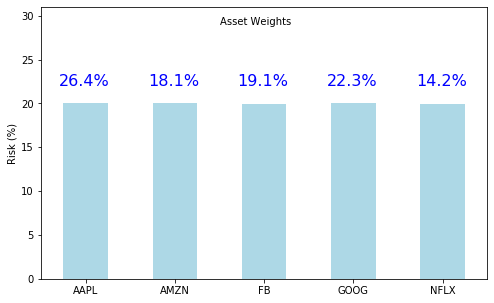

In [129]:
h = []
for i in range(5):
    for j in range(int(sigma_i[i]/sum(sigma_i)*1000)):
        h.append(i*2)
plt.figure(figsize=(8,5))
plt.hist(h, bins=np.arange(10)-0.5, range=(0, 10), color="lightblue")
plt.xlim(-1, 9)
plt.ylim(0, 310)
ind = np.arange(10) 
plt.xticks(np.arange(0,10,2), ('AAPL', 'AMZN', 'FB', 'GOOG', 'NFLX'))
plt.yticks(np.arange(0, 350, 50), np.arange(0, 35, 5))
plt.ylabel("Risk (%)")
plt.text(3., 290, "Asset Weights")
for i in range(5):
    plt.text(i*2-0.6, sigma_i[i]/sum(sigma_i)*1000+20, "{:2.1f}%".format(opts.x[i]*100), color='blue', fontsize=16)
plt.show()

In [131]:
def objective3(weights, target_risk, annual_covariance):
    variance = np.dot(weights.T, np.dot(annual_covariance, weights)) 
    sum = 0
    N = len(weights)
    for i in range(N):
        sum += (weights[i] - (target_risk[i]*variance)/(np.dot(annual_covariance, weights)[i]))**2 
    return sum

f_i = [0.3, 0.2, 0.2, 0.15, 0.15] 
args = (f_i, annual_covariance)
constraints = ({'type': 'eq', 'fun': sumWeights})                               
bounds = tuple((0, 1) for asset in range(numAssets))
opts = optimize.minimize(objective3, np.ones(numAssets) / float(numAssets), args=args, bounds=bounds, constraints=constraints)
print (opts)
sigma_i = []
for i in range(numAssets):
    std = np.sqrt(np.dot(opts.x.T, np.dot(annual_covariance, opts.x))) 
    a = opts.x[i]*np.dot(annual_covariance, opts.x)[i] 
    sigma_i.append(a/std)


     fun: 3.985449091312236e-07
     jac: array([-0.00090474,  0.00038776,  0.0009308 , -0.00032641,  0.0011355 ])
 message: 'Optimization terminated successfully.'
    nfev: 45
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.35019494, 0.17972679, 0.18831561, 0.16913951, 0.11262315])


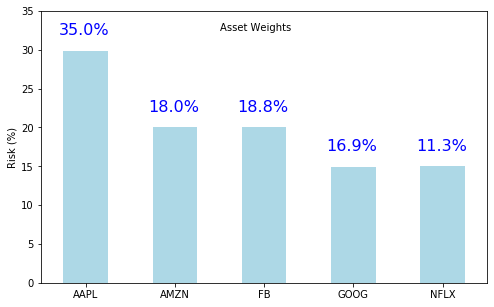

In [132]:
h = []
for i in range(5):
    for j in range(int(sigma_i[i]/sum(sigma_i)*1000)):
        h.append(i*2)

plt.figure(figsize=(8,5))
plt.hist(h, bins=np.arange(10)-0.5, range=(0, 10), color="lightblue")
plt.xlim(-1, 9)
plt.ylim(0, 310)
ind = np.arange(10) 
plt.xticks(np.arange(0,10,2), ('AAPL', 'AMZN', 'FB', 'GOOG', 'NFLX'))
plt.yticks(np.arange(0, 400, 50), np.arange(0, 40, 5))
plt.ylabel("Risk (%)")
plt.text(3., 325, "Asset Weights")
for i in range(5):
    plt.text(i*2-0.6, sigma_i[i]/sum(sigma_i)*1000+20, "{:2.1f}%".format(opts.x[i]*100), color='blue', fontsize=16)
plt.show()

In [136]:
def calc_diversification_ratio(w):
    # average weighted vol
    w_vol = np.dot(np.sqrt(np.diag(covariance)), w.T)
    # portfolio vol
    port_vol = np.sqrt(np.dot(w.T, np.dot(covariance, w)))
    diversification_ratio = w_vol/port_vol
    # return negative for minimization problem (maximize = minimize -)
    return -diversification_ratio

# w0: initial weight
# V: covariance matrix
# bnd: individual position limit
# long only: long only constraint
bnd = tuple((0, 1) for asset in range(numAssets))
cons = ({'type': 'eq', 'fun': sumWeights},)
#if long_only: # add in long only constraint
#cons = cons + ({'type': 'ineq', 'fun':  long_only_constraint},)
opts = optimize.minimize(calc_diversification_ratio, np.ones(numAssets) / float(numAssets)
               , bounds=bnd, 
               method='SLSQP', constraints=cons)
print (opts)

     fun: -1.3820226890251621
     jac: array([-1.87858939e-04,  1.40175223e-04, -3.96057963e-04, -7.59512186e-05,
        6.11126423e-04])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.35727486, 0.17943996, 0.17225915, 0.09847119, 0.19255483])


Diversification:  1.3820226890251621


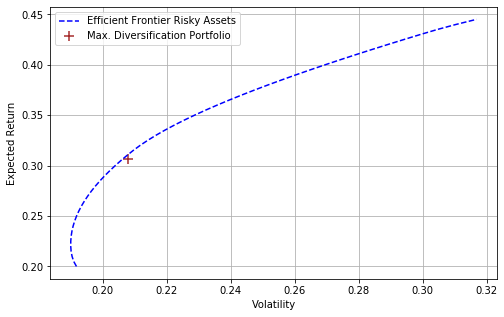

In [142]:
ret = np.sum(annual_expected*opts.x)
vol = np.sqrt(np.dot(opts.x.T, np.dot(annual_covariance, opts.x))) 
print ("Diversification: ", -opts.fun)
plt.figure(figsize=(8,5))
plt.plot(returns[:,0], returns[:,1], label="Efficient Frontier Risky Assets", color='blue', linestyle="--") 
plt.xlabel("Volatility")
plt.ylabel("Expected Return")
plt.scatter(vol, ret, label="Max. Diversification Portfolio", color="brown", marker="+",s=100), 
plt.grid(True)
plt.legend()
plt.show()